# ☀ Analysis of Brisbane Photovoltaic Installation Data ☀


## Introduction

For this excerise I will take open data on demographic profiles of various suburbs around Brisbane to answer four questions relating to a problem statement. 
The problem statement is:
> Our customer wishes to use this data to understand possible demand for solar panel installations when entering a new region, where counts of installations will not be available but the other factors will be present. This will allow them to focus advertising on suburbs where they are most likely to have a high demand.

The questions are:
1. Please provide a summary and analysis of the factors that you determine to be important for the prediction of the likely number of installations.
2. Please give a description of any surprising findings or spurious factors that you believe may generalize poorly to new regions.
3. Please provide any caveats (or “gotchas”) that you believe may undermine the power of any predictive model developed from these factors.
4. Please outline any data you would wish to augment this dataset with to make a more powerful predictive model or any experiments you would propose to rule out spurious correlations.

I will include a preamble to each question that tries to explain my approach and then I will follow it with analysis and finally by a conclusion and answer.

---

## Import packages and data

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import re

In [2]:
# Read in data file to dataframe
df = pd.read_excel('Brisbane Suburbs Stats Separated V2.0.xlsx')

---

## Question 1

> Please provide a summary and analysis of the factors that you determine to be important for the prediction of the likely number of installations.

My first thoughts are to understand and categorise the columns in the dataframe.

Relating this back to the problem statement, we should try to reconcile these against different levers that may have an affect on demand for solar panel installations. 

Below are some thoughts for factors that might contribute off the top of my head.
* Economic levers:
    - Financial position of residents
        - Renters
        - Mortgage/owned
        - Employment
            - Salary
    - Construction and real estate
        - New builds
        - Renovations
        - Sales
        - Subsidies? (i.e. are there incentives to build solar panels when building/renovating?)
            - Do these subsidies apply outside of Brisbane/QLD?
    - Electricity usage
    - Proximity to supplier
        - Is this confounded by geography?
* Geographical levers:
    - Weather
    - Altitude
    - Proximity to supplier
* Demographic levers:
    - Do particular demographies have higher demand?
    - Do changing demographies drive demand?
    - Can election results in suburb predict demand for solar? (e.g. do Green's voters install more solar panels?)
    - Penetration in suburb/neighbouring suburb (i.e. does a rising number of solar panels make others consider installation?)
    - Industry of residents
    - Population density

Limitations:
* We might be missing some relationships because of the spread of data in different years


Methods for finding these factors?

List some ideas here when I have them to keep track....

Correlation


---

In [3]:
# Derive some extra columns

# Some extra time series data
# I'm doing this in different for loops to make sure the orders are easy to pull out
for year in range(2002, 2019):
    df[f'Avg new house value {year}'] = df[f'BA Value of new houses {year}']/df[f'BA New houses {year}']
for year in range(2002, 2019):
    df[f'Avg alts & adds {year}'] = (df[f'BA Value of alts & adds to residential building {year}']/df[f'BA Total dwellings {year}'])

# Some other columns that will be helpful
df['Total Population (2017)'] = df[df.columns[5:23]].sum(axis=1)  # I've assumed the age columns capture everyone living in a given suburb
df['Approx km2'] = df['Total Population (2017)']/df['Population density (ERP at 30 June) (persons/km2) 2018']  # Here I've assumed the population has not changed much between 2017 and 2018

# Replace infinite values with NaNs so that they don't mess up averages, etc
df.replace([np.inf, -np.inf], np.nan,inplace=True)

In [9]:
# Isolate index and target columns
idx_col           = df.columns[2:3]  # I don't think I need Suburb or Postcode - Just use ABS code as index
target_col        = df.columns[101:102]

# Categorise the columns into different groups
dist_cols         = df.columns[3:5]
age_cols          = df.columns[5:23]
pop_cols          = df.columns[23:24].union(['Total Population (2017)', 'Approx km2'])
ethnicity_cols    = df.columns[24:38]
construction_cols = df.columns[38:42].union(df.columns[113:266])
industry_cols     = df.columns[42:61]    # Rental is included in here?
finance_cols      = df.columns[61:94].union(df.columns[105:113])   # Note: mixture of 2016 and 2018 data in here
housing_cols      = df.columns[94:101]
solar_cols        = df.columns[101:105]  # NOTE: Includes target column

In [10]:
df[construction_cols.union(['Suburb'])]

Attached Dwellings - median sale price ($) 2016  \
0                                           427500.0   
1                                           455000.0   
2                                           475000.0   
3                                           395000.0   
4                                           305000.0   
..                                               ...   
259                                              NaN   
260                                         390000.0   
261                                         341500.0   
262                                         489000.0   
263                                         369000.0   

     Attached Dwellings - number of transfers (no.) 2016  \
0                                                 57.0     
1                                                 73.0     
2                                                103.0     
3                                                 43.0     
4                                                 29.0     
..                                                 ...     
259                                                NaN     
260                                               82.0     
261                                               70.0     
262                                              140.0     
263                                               90.0     

     Avg alts & adds 2002  Avg alts & adds 2003  Avg alts & adds 2004  \
0                4.781466             14.820930             36.932727   
1              391.625000                   NaN            126.058333   
2              173.938095             80.210811            130.278947   
3               13.214545            115.810000            264.545455   
4                5.980435              4.424444              2.515190   
..                    ...                   ...                   ...   
259             32.774000             28.403030             92.812121   
260             47.241176             48.225000             50.578571   
261              6.357639             11.051087             87.884848   
262             43.481522             83.205714             70.400000   
263           1807.300000            313.900000            348.542857   

     Avg alts & adds 2005  Avg alts & adds 2006  Avg alts & adds 2007  \
0               22.109375            112.940000             44.885294   
1               31.296875            141.820000             25.552000   
2              232.083333             87.123810            111.152632   
3              439.650000            458.366667            455.525000   
4               12.107246              9.385393             32.175000   
..                    ...                   ...                   ...   
259            134.391304            327.817647            177.678571   
260             34.202174             70.188750            138.082051   
261            222.611111             48.919444             29.173333   
262             75.021429             77.289610            102.770000   
263             56.838710             17.556818             38.937931   

     Avg alts & adds 2008  Avg alts & adds 2009  ...  \
0               63.066667             83.487879  ...   
1              477.160000           1297.500000  ...   
2              146.675000            239.563158  ...   
3              167.255556            219.970000  ...   
4               15.049123             13.045652  ...   
..                    ...                   ...  ...   
259            264.481250            159.572222  ...   
260            119.273611            129.395349  ...   
261             43.240909             35.419540  ...   
262             22.627536            123.530612  ...   
263             23.235593             27.491026  ...   

     BA Value of total residential building 2012  \
0                                         4539.9   
1                                        15734.0   
2                           

In [11]:
# Create time series with BA data
start = 113
yrs = 17
re_pattern = r'(.*) (\d{4})'

df_time = None

for i in range(9):
    melt_vars = df.columns[start:start+yrs]
    start += yrs  # increment for next iteration
    name = re.search(re_pattern, melt_vars[0])[1]
    col_rename = {
        col: int(re.search(re_pattern, col)[2]) for col in melt_vars
    }
    
    if df_time is None:
        df_time = pd.melt(
            df[idx_col.union(melt_vars)].rename(columns=col_rename),
            id_vars=idx_col,
            var_name='Year',
            value_name=name
        )

    else:
        temp = pd.melt(
            df[idx_col.union(melt_vars)].rename(columns=col_rename),
            id_vars=idx_col,
            var_name='Year',
            value_name=name
        ).set_index(['ABS Code', 'Year'])
        
        df_time = df_time.join(
            temp, 
            on=['ABS Code', 'Year'], 
            how='left'
        )
        
# Add in mean, Q1, median, Q3 for plotting/comparison
df_time_agg = None
agg_label = 'Agg'

# Mean
df_time_agg = df_time.drop(columns=idx_col).groupby('Year').mean().reset_index()
df_time_agg[agg_label] = 'Mean'

# Q1, Median, Q3
temp = df_time.drop(columns=idx_col).groupby('Year').quantile(0.25).reset_index()
temp[agg_label] = 'Q1'
df_time_agg = pd.concat(
    [df_time_agg, temp]
)

temp = df_time.drop(columns=idx_col).groupby('Year').quantile(0.5).reset_index()
temp[agg_label] = 'Median'
df_time_agg = pd.concat(
    [df_time_agg, temp]
)

temp = df_time.drop(columns=idx_col).groupby('Year').quantile(0.75).reset_index()
temp[agg_label] = 'Q3'
df_time_agg = pd.concat(
    [df_time_agg, temp]
)

The cell below is just for testing

In [12]:
# Test to see I captured all columns
all_cols = idx_col.union(target_col)\
    .union(dist_cols).union(age_cols).union(pop_cols).union(ethnicity_cols)\
    .union(construction_cols).union(industry_cols).union(finance_cols).union(housing_cols).union(solar_cols)

# This helps me 
#list(enumerate(df.columns))[:]

# Check I have all columns present and accounted for (I'm ok leaving out Suburb and Postcode)
[(i, col) for i, col in enumerate(df.columns) if col not in all_cols]

[(0, 'Suburb'), (1, 'Postcode ')]

Find correlation using Pearson and Spearman's correlation


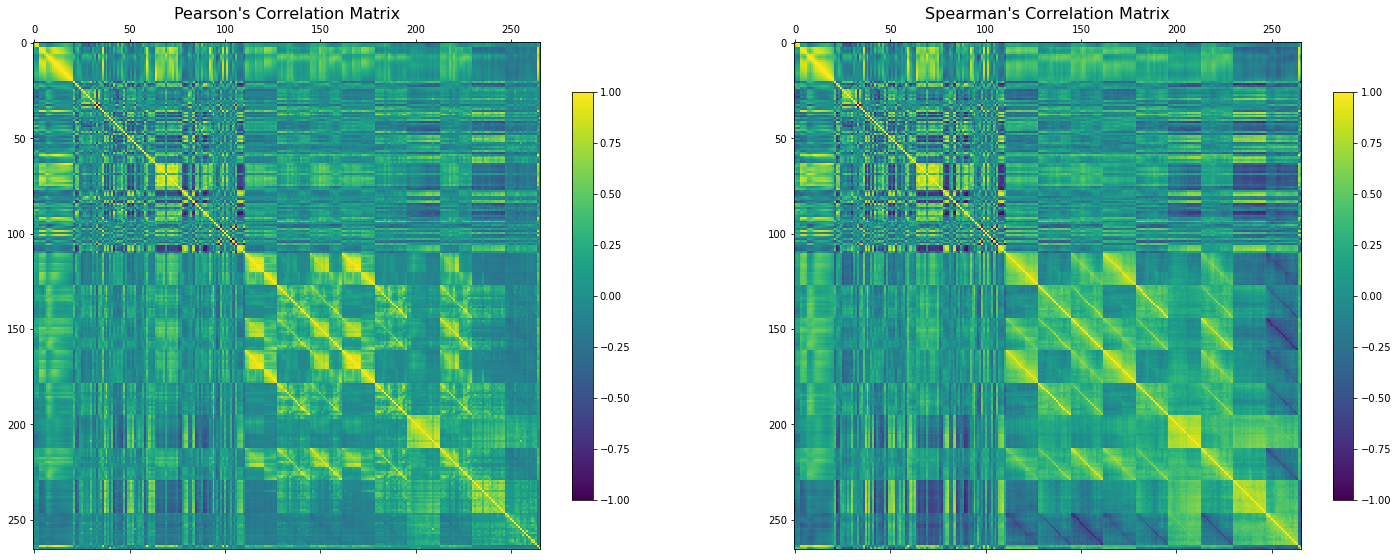

In [13]:
correlation_mat = df.corr(method='pearson')
spearman_mat = df.corr(method='spearman')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

plt.subplot(1, 2, 1)
plt.matshow(correlation_mat, fignum=False)
plt.title("Pearson's Correlation Matrix", fontsize=16)

cb = plt.colorbar(shrink=0.75)
cb.ax.tick_params()

plt.subplot(1, 2, 2)
plt.matshow(spearman_mat, fignum=False)
plt.title("Spearman's Correlation Matrix", fontsize=16)

cb = plt.colorbar(shrink=0.75)
cb.ax.tick_params()
plt.show()

There's a lot going on here due to the sheer number of columns, but we can definitely see plenty of dark blue and yellow indicating there is correlation to be found. The blocks in the bottom right are from the time series data which makes sense that they are correlated. Let's take a look at the distribution of these correlation coefficients to see how strong some of them are.

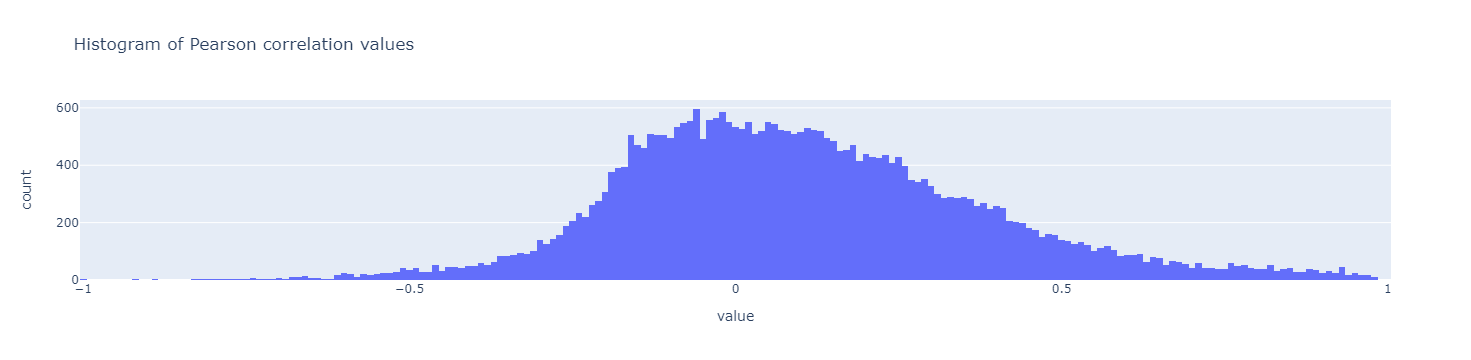

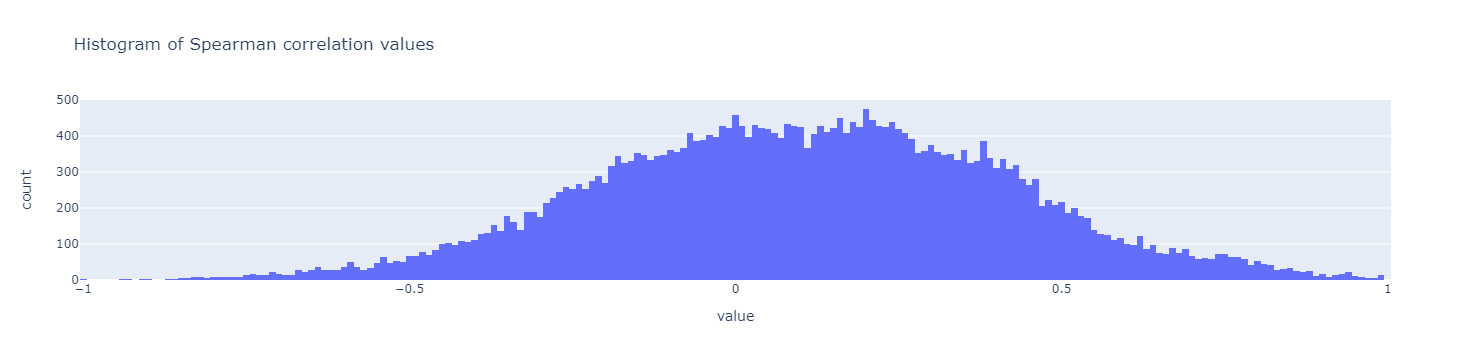

Number of pairs with Pearson correlation in [-1.00, -0.80): 22        Number of pairs with Spearman correlation in [-1.00, -0.80): 58
Number of pairs with Pearson correlation in [-0.80, -0.60): 139       Number of pairs with Spearman correlation in [-0.80, -0.60): 381
Number of pairs with Pearson correlation in [-0.60, -0.40): 638       Number of pairs with Spearman correlation in [-0.60, -0.40): 1360
Number of pairs with Pearson correlation in [-0.40, -0.20): 2820      Number of pairs with Spearman correlation in [-0.40, -0.20): 4060
Number of pairs with Pearson correlation in [-0.20, 0.00): 10056      Number of pairs with Spearman correlation in [-0.20, 0.00): 7321
Number of pairs with Pearson correlation in [0.00, 0.20): 10067       Number of pairs with Spearman correlation in [0.00, 0.20): 8391
Number of pairs with Pearson correlation in [0.20, 0.40): 6753        Number of pairs with Spearman correlation in [0.20, 0.40): 7566
Number of pairs with Pearson correlation in [0.40, 0.60)

In [14]:
# Flatten correlation matrix
# Note: only need to count up to the ith element in each row since matrix is symmetric with 1s along the 
#       diagonal which we can exclude (as they offer no insight)
corr_vals = [item for i, row in enumerate(correlation_mat.values.tolist()) for item in row[:i]]
spearman_vals = [item for i, row in enumerate(spearman_mat.values.tolist()) for item in row[:i]]

# Histogram of correlation values to determine what the correlation looks like
# This could be better as a density but I find it more informative as a count
fig = px.histogram(
    corr_vals,
    title='Histogram of Pearson correlation values'
)

fig.update_layout(showlegend=False)
fig.show()

fig = px.histogram(
    spearman_vals,
    title='Histogram of Spearman correlation values',
)

fig.update_layout(showlegend=False)
fig.show()

# This can probably go but I was just interested in seeing the counts
n = 10
for i in range(n):
    lower, upper = 2*i/n - 1, 2*(i+1)/n - 1
    # Print number of pairs in different correlation bands for extra context
    print(
        f"Number of pairs with Pearson correlation in [{lower:0.2f}, {upper:0.2f}): {len([v for v in corr_vals if lower <= v < upper])}".ljust(70) +\
        f"Number of pairs with Spearman correlation in [{lower:0.2f}, {upper:0.2f}): {len([v for v in spearman_vals if lower <= v < upper])}"
    )

print("-"*140)
    
# Just to make sure there are none perfectly correlated
print(
    f"Number of pairs with Pearson correlation == {-1:0.2f}: {len([v for v in corr_vals if v == -1])}".ljust(70) +\
    f"Number of pairs with Spearman correlation == {-1:0.2f}: {len([v for v in spearman_vals if v == -1])}"
)

print(
    f"Number of pairs with Pearson correlation == {1:0.2f}: {len([v for v in corr_vals if v == 1])}".ljust(70) +\
    f"Number of pairs with Spearman correlation == {1:0.2f}: {len([v for v in spearman_vals if v == 1])}"
)

Interesting to see that there are two pairs with a Spearman correlation of -1; let's investigate!

In [15]:
spearman_mat[b := (spearman_mat == -1).any()][spearman_mat[b].index.values]

Households where mortgage repayments are less than 30% of household income (%) 2016  \
Households where mortgage repayments are less t...                                           1.000000                                     
Households with mortgage repayments greater tha...                                          -1.000000                                     
Households where rent payments are less than 30...                                          -0.535715                                     
Households with rent payments greater than or e...                                           0.535715                                     

                                                    Households with mortgage repayments greater than or equal to 30% of household income (%) 2016  \
Households where mortgage repayments are less t...                                          -1.000000                                               
Households with mortgage repayments greater tha...                                           1.000000                                               
Households where rent payments are less than 30...                                           0.535715                                               
Households with rent payments greater than or e...                                          -0.535715                                               

                                                    Households where rent payments are less than 30% of household income (%) 2016  \
Households where mortgage repayments are less t...                                          -0.535715                               
Households with mortgage repayments greater tha...                                           0.535715                               
Households where rent payments are less than 30...                                           1.000000                               
Households with rent payments greater than or e...                                          -1.000000                               

                                                    Households with rent payments greater than or equal to 30% of household income (%) 2016  
Households where mortgage repayments are less t...                                           0.535715                                        
Households with mortgage repayments greater tha...                                          -0.535715                                        
Households where rent payments are less than 30...                                          -1.000000                                        
Households with rent payments greater than or e...                                           1.000000

It makes total sense that these are inversely proportional. The Spearman correlation has identified that for each pair of variables (v1, v2) with correlation == -1, v1 = 1-v2.

They're clearly dependent, so we should remove one of these columns from each pair if we want to do regression.

Let's examine some more of the correlations closer to -1 and 1.

In [16]:
# I'm going to make a little lambda function to speed this up
# Note: it will break for leq=1 but pandas is inelegant for excluding diagonals
corr_between = lambda d, gt, leq: d[(b := ((gt < d) & (d <= leq)).any())][d[b].index.values]

def corr_matrices_between(d, gt, leq):
    """
    This takes a correlation matrix d and finds blocks of correlation with 
    coefficients greater than gt and less than or equal to leq.
    """
    # Iterate over variables that have a correlation coefficient between gt and leq
    def recurse(varlist, d=d, gt=gt, leq=leq):
        
        s = ((gt < d.loc[varlist]) & (d.loc[varlist] <= leq)).any()
        new = s[s].index
        
        if len(new.union(varlist)) == len(varlist):
            return varlist
        else:
            return recurse(new.union(varlist), d, gt, leq)
    
    blocks = []
    used_vars = None
    all_indices = d[((gt < d) & (d <= leq)).any()].index.values
    
    for i, var in enumerate(all_indices):
        if used_vars is None:
            used_vars = recurse(all_indices[i:i+1])
            blocks.append(d[used_vars].loc[used_vars])
        elif var not in used_vars:
            new_vars = recurse(all_indices[i:i+1])
            blocks.append(d[new_vars].loc[new_vars])
            used_vars = used_vars.union(new_vars)
        else:
            pass
    
    return blocks

I'm now going to dump out a bunch of correlation matrices to look at

In [17]:
gt, leq = (-1, -0.9)
corr_mats = corr_matrices_between(spearman_mat, gt, leq)

print(f"There are {len(corr_mats)} total blocks with dependencies between {gt} and {leq}")
for i, block in enumerate(corr_mats):
    print(f"Dependency block {i+1}:")
    display(block)

There are 3 total blocks with dependencies between -1 and -0.9
Dependency block 1:


Australian citizen (%) 2016  \
Australian citizen (%) 2016                            1.000000   
Not an Australian citizen (%) 2016                    -0.930939   

                                    Not an Australian citizen (%) 2016  
Australian citizen (%) 2016                                  -0.930939  
Not an Australian citizen (%) 2016                            1.000000

Dependency block 2:


Labourers (%) 2016  \
Labourers (%) 2016                                            1.000000   
Machinery operators and drivers (%) 2016                      0.874418   
Persons over 15 earning $2000-$2999 per week (%...           -0.927794   
Persons over 15 earning $3000 or more per week ...           -0.911329   
Professional Scientific & Technical Services (%...           -0.874502   
Professionals (%) 2016                                       -0.868043   
SEIFA decile ranking - Index of Education and O...           -0.920349   
SEIFA decile ranking - Index of Relative Socio-...           -0.939870   
SEIFA decile ranking - Index of Relative Socio-...           -0.902990   

                                                    Machinery operators and drivers (%) 2016  \
Labourers (%) 2016                                                                  0.874418   
Machinery operators and drivers (%) 2016                                            1.000000   
Persons over 15 earning $2000-$2999 per week (%...                                 -0.822430   
Persons over 15 earning $3000 or more per week ...                                 -0.895178   
Professional Scientific & Technical Services (%...                                 -0.913648   
Professionals (%) 2016                                                             -0.914181   
SEIFA decile ranking - Index of Education and O...                                 -0.937694   
SEIFA decile ranking - Index of Relative Socio-...                                 -0.850811   
SEIFA decile ranking - Index of Relative Socio-...                                 -0.739244   

                                                    Persons over 15 earning $2000-$2999 per week (%) 2016  \
Labourers (%) 2016                                                                          -0.927794       
Machinery operators and drivers (%) 2016                                                    -0.822430       
Persons over 15 earning $2000-$2999 per week (%...                                           1.000000       
Persons over 15 earning $3000 or more per week ...                                           0.915522       
Professional Scientific & Technical Services (%...                                           0.877665       
Professionals (%) 2016                                                                       0.855389       
SEIFA decile ranking - Index of Education and O...                                           0.897999       
SEIFA decile ranking - Index of Relative Socio-...                                           0.940635       
SEIFA decile ranking - Index of Relative Socio-...                                           0.898475       

                                                    Persons over 15 earning $3000 or more per week (%) 2016  \
Labourers (%) 2016                                                                          -0.911329         
Machinery operators and drivers (%) 2016                                                    -0.895178         
Persons over 15 earning $2000-$2999 per week (%...                                           0.915522         
Persons over 15 earning $3000 or more per week ...                                           1.000000         
Professional Scientific & Technical Services (%...                                           0.881976         
Professionals (%) 2016                                                                       0.844251         
SEIFA decile ranking - Index of Education and O...                                           0.915433         
SEIFA decile ranking - Index of Relative Socio-...                                           0.923385         
SEIFA decile ranking - Index of Relative Socio-...                                           0.847151         

                                                    Professional Scientific & Technical Services (%) 2016  \
Labourers (%) 2016                     

Dependency block 3:


Households where rent payments are less than 30% of household income (%) 2016  \
Households where rent payments are less than 30...                                           1.000000                               
Rented (%) 2016                                                                             -0.937898                               

                                                    Rented (%) 2016  
Households where rent payments are less than 30...        -0.937898  
Rented (%) 2016                                            1.000000

In [18]:
gt, leq = (-1, -0.9)
corr_mats = corr_matrices_between(correlation_mat, gt, leq)

print(f"There are {len(corr_mats)} total blocks with dependencies between {gt} and {leq}")
for i, block in enumerate(corr_mats):
    print(f"Dependency block {i+1}:")
    display(block)

There are 3 total blocks with dependencies between -1 and -0.9
Dependency block 1:


Machinery operators and drivers (%) 2016  \
Machinery operators and drivers (%) 2016                                            1.000000   
SEIFA decile ranking - Index of Education and O...                                 -0.922187   

                                                    SEIFA decile ranking - Index of Education and Occupation (IEO) 2016  
Machinery operators and drivers (%) 2016                                                    -0.922187                    
SEIFA decile ranking - Index of Education and O...                                           1.000000

Dependency block 2:


Labourers (%) 2016  \
Labourers (%) 2016                                            1.000000   
SEIFA decile ranking - Index of Relative Socio-...           -0.918736   
SEIFA decile ranking - Index of Relative Socio-...           -0.904158   

                                                    SEIFA decile ranking - Index of Relative Socio-Economic Advantage and Disadvantage (IRSAD) 2016  \
Labourers (%) 2016                                                                          -0.918736                                                 
SEIFA decile ranking - Index of Relative Socio-...                                           1.000000                                                 
SEIFA decile ranking - Index of Relative Socio-...                                           0.963091                                                 

                                                    SEIFA decile ranking - Index of Relative Socio-Economic Disadvantage (IRSD) 2016  
Labourers (%) 2016                                                                          -0.904158                                 
SEIFA decile ranking - Index of Relative Socio-...                                           0.963091                                 
SEIFA decile ranking - Index of Relative Socio-...                                           1.000000

Dependency block 3:


Households where rent payments are less than 30% of household income (%) 2016  \
Households where rent payments are less than 30...                                           1.000000                               
Households with rent payments greater than or e...                                          -1.000000                               
Rented (%) 2016                                                                             -0.925457                               

                                                    Households with rent payments greater than or equal to 30% of household income (%) 2016  \
Households where rent payments are less than 30...                                          -1.000000                                         
Households with rent payments greater than or e...                                           1.000000                                         
Rented (%) 2016                                                                              0.925457                                         

                                                    Rented (%) 2016  
Households where rent payments are less than 30...        -0.925457  
Households with rent payments greater than or e...         0.925457  
Rented (%) 2016                                            1.000000

In [19]:
gt, leq = (0.95, 0.999)
corr_mats = corr_matrices_between(spearman_mat, gt, leq)

print(f"There are {len(corr_mats)} total blocks with dependencies between {gt} and {leq}")
for i, block in enumerate(corr_mats):
    print(f"Dependency block {i+1}:")
    display(block)

There are 26 total blocks with dependencies between 0.95 and 0.999
Dependency block 1:


Distance Time from Cusomer - min  \
Distance Time from Cusomer - min                           1.00000   
Distance from Customer - Km                                0.96031   

                                  Distance from Customer - Km  
Distance Time from Cusomer - min                      0.96031  
Distance from Customer - Km                           1.00000

Dependency block 2:


Persons - 0-4 years (no.) 2017  \
Persons - 0-4 years (no.) 2017                          1.000000   
Persons - 10-14 years (no.) 2017                        0.885543   
Persons - 5-9 years (no.) 2017                          0.951985   

                                  Persons - 10-14 years (no.) 2017  \
Persons - 0-4 years (no.) 2017                            0.885543   
Persons - 10-14 years (no.) 2017                          1.000000   
Persons - 5-9 years (no.) 2017                            0.970684   

                                  Persons - 5-9 years (no.) 2017  
Persons - 0-4 years (no.) 2017                          0.951985  
Persons - 10-14 years (no.) 2017                        0.970684  
Persons - 5-9 years (no.) 2017                          1.000000

Dependency block 3:


Persons - 40-44 years (no.) 2017  \
Persons - 40-44 years (no.) 2017                           1.000000   
Persons - 45-49 years (no.) 2017                           0.967917   
Persons - 50-54 years (no.) 2017                           0.928336   
Persons - 55-59 years (no.) 2017                           0.893264   
Persons - 60-64 years (no.) 2017                           0.856827   
Persons - 65-69 years (no.) 2017                           0.797467   
Persons - 70-74 years (no.) 2017                           0.745962   
Persons - 75-79 years (no.) 2017                           0.694179   
Persons - 80-84 years (no.) 2017                           0.624546   
Total Population (2017)                                    0.953416   
Total persons employed (no.) 2016                          0.950462   

                                   Persons - 45-49 years (no.) 2017  \
Persons - 40-44 years (no.) 2017                           0.967917   
Persons - 45-49 years (no.) 2017                           1.000000   
Persons - 50-54 years (no.) 2017                           0.970649   
Persons - 55-59 years (no.) 2017                           0.936170   
Persons - 60-64 years (no.) 2017                           0.896940   
Persons - 65-69 years (no.) 2017                           0.844570   
Persons - 70-74 years (no.) 2017                           0.795125   
Persons - 75-79 years (no.) 2017                           0.735457   
Persons - 80-84 years (no.) 2017                           0.656508   
Total Population (2017)                                    0.928699   
Total persons employed (no.) 2016                          0.923647   

                                   Persons - 50-54 years (no.) 2017  \
Persons - 40-44 years (no.) 2017                           0.928336   
Persons - 45-49 years (no.) 2017                           0.970649   
Persons - 50-54 years (no.) 2017                           1.000000   
Persons - 55-59 years (no.) 2017                           0.975755   
Persons - 60-64 years (no.) 2017                           0.945004   
Persons - 65-69 years (no.) 2017                           0.898260   
Persons - 70-74 years (no.) 2017                           0.847962   
Persons - 75-79 years (no.) 2017                           0.787023   
Persons - 80-84 years (no.) 2017                           0.702693   
Total Population (2017)                                    0.917869   
Total persons employed (no.) 2016                          0.895464   

                                   Persons - 55-59 years (no.) 2017  \
Persons - 40-44 years (no.) 2017                           0.893264   
Persons - 45-49 years (no.) 2017                           0.936170   
Persons - 50-54 years (no.) 2017                           0.975755   
Persons - 55-59 years (no.) 2017                           1.000000   
Persons - 60-64 years (no.) 2017                           0.975897   
Persons - 65-69 years (no.) 2017                           0.941361   
Persons - 70-74 years (no.) 2017                           0.891973   
Persons - 75-79 years (no.) 2017                           0.833294   
Persons - 80-84 years (no.) 2017                           0.747587   
Total Population (2017)                                    0.909756   
Total persons employed (no.) 2016                          0.875368   

                                   Persons - 60-64 years (no.) 2017  \
Persons - 40-44 years (no.) 2017                           0.856827   
Persons - 45-49 years (no.) 2017                           0.896940   
Persons - 50-54 years (no.) 2017                           0.945004   
Persons - 55-59 years (no.) 2017                           0.975897   
Persons - 60-64 years (no.) 2017                           1.000000   
Persons - 65-69 years (no.) 2017                           0.974106   
Persons - 70-74 years (no.) 2017                           0.936957   
Persons - 75-79 years (no.) 2017                       

Dependency block 4:


Professional Scientific & Technical Services (%) 2016  \
Professional Scientific & Technical Services (%...                                           1.000000       
Professionals (%) 2016                                                                       0.967909       
SEIFA decile ranking - Index of Education and O...                                           0.963459       

                                                    Professionals (%) 2016  \
Professional Scientific & Technical Services (%...                0.967909   
Professionals (%) 2016                                            1.000000   
SEIFA decile ranking - Index of Education and O...                0.963490   

                                                    SEIFA decile ranking - Index of Education and Occupation (IEO) 2016  
Professional Scientific & Technical Services (%...                                           0.963459                    
Professionals (%) 2016                                                                       0.963490                    
SEIFA decile ranking - Index of Education and O...                                           1.000000

Dependency block 5:


Carer Allowance (no.) 2018  \
Carer Allowance (no.) 2018                    1.000000   
Carer Payment (no.) 2018                      0.950424   

                            Carer Payment (no.) 2018  
Carer Allowance (no.) 2018                  0.950424  
Carer Payment (no.) 2018                    1.000000

Dependency block 6:


Disability Support Pension (no.) 2018  \
Disability Support Pension (no.) 2018                               1.000000   
Newstart Allowance (no.) 2018                                       0.957225   

                                       Newstart Allowance (no.) 2018  
Disability Support Pension (no.) 2018                       0.957225  
Newstart Allowance (no.) 2018                               1.000000

Dependency block 7:


Family Tax Benefit A (no.) 2018  \
Family Tax Benefit A (no.) 2018                               1.000000   
Family Tax Benefit B (no.) 2018                               0.997224   
Parenting Payment - Single (no.) 2018                         0.952547   

                                       Family Tax Benefit B (no.) 2018  \
Family Tax Benefit A (no.) 2018                               0.997224   
Family Tax Benefit B (no.) 2018                               1.000000   
Parenting Payment - Single (no.) 2018                         0.962786   

                                       Parenting Payment - Single (no.) 2018  
Family Tax Benefit A (no.) 2018                                     0.952547  
Family Tax Benefit B (no.) 2018                                     0.962786  
Parenting Payment - Single (no.) 2018                               1.000000

Dependency block 8:


Small-scale solar panel system installations (no.) 2017  \
Small-scale solar panel system installations (n...                                           1.000000         
Solar water heater installations (no.) 2017                                                  0.962002         

                                                    Solar water heater installations (no.) 2017  
Small-scale solar panel system installations (n...                                     0.962002  
Solar water heater installations (no.) 2017                                            1.000000

Dependency block 9:


BA New houses 2002  BA Value of new houses 2002
BA New houses 2002                     1.000000                     0.957224
BA Value of new houses 2002            0.957224                     1.000000

Dependency block 10:


BA New other residential building 2002  \
BA New other residential building 2002                                         1.000000   
BA Value of new other residential building 2002                                0.992096   

                                                 BA Value of new other residential building 2002  
BA New other residential building 2002                                                  0.992096  
BA Value of new other residential building 2002                                         1.000000

Dependency block 11:


BA New other residential building 2003  \
BA New other residential building 2003                                         1.000000   
BA Value of new other residential building 2003                                0.993317   

                                                 BA Value of new other residential building 2003  
BA New other residential building 2003                                                  0.993317  
BA Value of new other residential building 2003                                         1.000000

Dependency block 12:


BA New other residential building 2004  \
BA New other residential building 2004                                         1.000000   
BA Value of new other residential building 2004                                0.987996   

                                                 BA Value of new other residential building 2004  
BA New other residential building 2004                                                  0.987996  
BA Value of new other residential building 2004                                         1.000000

Dependency block 13:


BA New other residential building 2005  \
BA New other residential building 2005                                          1.00000   
BA Value of new other residential building 2005                                 0.98497   

                                                 BA Value of new other residential building 2005  
BA New other residential building 2005                                                   0.98497  
BA Value of new other residential building 2005                                          1.00000

Dependency block 14:


BA New other residential building 2006  \
BA New other residential building 2006                                         1.000000   
BA Value of new other residential building 2006                                0.984794   

                                                 BA Value of new other residential building 2006  
BA New other residential building 2006                                                  0.984794  
BA Value of new other residential building 2006                                         1.000000

Dependency block 15:


BA New other residential building 2007  \
BA New other residential building 2007                                         1.000000   
BA Value of new other residential building 2007                                0.988025   

                                                 BA Value of new other residential building 2007  
BA New other residential building 2007                                                  0.988025  
BA Value of new other residential building 2007                                         1.000000

Dependency block 16:


BA New other residential building 2008  \
BA New other residential building 2008                                         1.000000   
BA Value of new other residential building 2008                                0.982148   

                                                 BA Value of new other residential building 2008  
BA New other residential building 2008                                                  0.982148  
BA Value of new other residential building 2008                                         1.000000

Dependency block 17:


BA New other residential building 2009  \
BA New other residential building 2009                                         1.000000   
BA Value of new other residential building 2009                                0.983008   

                                                 BA Value of new other residential building 2009  
BA New other residential building 2009                                                  0.983008  
BA Value of new other residential building 2009                                         1.000000

Dependency block 18:


BA New other residential building 2010  \
BA New other residential building 2010                                         1.000000   
BA Value of new other residential building 2010                                0.990207   

                                                 BA Value of new other residential building 2010  
BA New other residential building 2010                                                  0.990207  
BA Value of new other residential building 2010                                         1.000000

Dependency block 19:


BA New other residential building 2011  \
BA New other residential building 2011                                         1.000000   
BA Value of new other residential building 2011                                0.990734   

                                                 BA Value of new other residential building 2011  
BA New other residential building 2011                                                  0.990734  
BA Value of new other residential building 2011                                         1.000000

Dependency block 20:


BA New other residential building 2012  \
BA New other residential building 2012                                         1.000000   
BA Value of new other residential building 2012                                0.994807   

                                                 BA Value of new other residential building 2012  
BA New other residential building 2012                                                  0.994807  
BA Value of new other residential building 2012                                         1.000000

Dependency block 21:


BA New other residential building 2013  \
BA New other residential building 2013                                         1.000000   
BA Value of new other residential building 2013                                0.994382   

                                                 BA Value of new other residential building 2013  
BA New other residential building 2013                                                  0.994382  
BA Value of new other residential building 2013                                         1.000000

Dependency block 22:


BA New other residential building 2014  \
BA New other residential building 2014                                         1.000000   
BA Value of new other residential building 2014                                0.992175   

                                                 BA Value of new other residential building 2014  
BA New other residential building 2014                                                  0.992175  
BA Value of new other residential building 2014                                         1.000000

Dependency block 23:


BA New other residential building 2015  \
BA New other residential building 2015                                         1.000000   
BA Value of new other residential building 2015                                0.993505   

                                                 BA Value of new other residential building 2015  
BA New other residential building 2015                                                  0.993505  
BA Value of new other residential building 2015                                         1.000000

Dependency block 24:


BA New other residential building 2016  \
BA New other residential building 2016                                         1.000000   
BA Value of new other residential building 2016                                0.992836   

                                                 BA Value of new other residential building 2016  
BA New other residential building 2016                                                  0.992836  
BA Value of new other residential building 2016                                         1.000000

Dependency block 25:


BA New other residential building 2017  \
BA New other residential building 2017                                         1.000000   
BA Value of new other residential building 2017                                0.986633   

                                                 BA Value of new other residential building 2017  
BA New other residential building 2017                                                  0.986633  
BA Value of new other residential building 2017                                         1.000000

Dependency block 26:


BA New other residential building 2018  \
BA New other residential building 2018                                          1.00000   
BA Value of new other residential building 2018                                 0.99184   

                                                 BA Value of new other residential building 2018  
BA New other residential building 2018                                                   0.99184  
BA Value of new other residential building 2018                                          1.00000

In [20]:
# Check if other New houses years correlate highly as well
y = 2009
l = [f'BA New houses {y}', f'BA Value of new houses {y}']

spearman_mat[l].loc[l]

BA New houses 2009  BA Value of new houses 2009
BA New houses 2009                     1.000000                     0.923616
BA Value of new houses 2009            0.923616                     1.000000

In [21]:
gt, leq = (0.95, 0.999)
corr_mats = corr_matrices_between(correlation_mat, gt, leq)

print(f"There are {len(corr_mats)} total blocks with dependencies between {gt} and {leq}")
for i, block in enumerate(corr_mats):
    print(f"Dependency block {i+1}:")
    display(block)

There are 33 total blocks with dependencies between 0.95 and 0.999
Dependency block 1:


Persons - 0-4 years (no.) 2017  \
Persons - 0-4 years (no.) 2017                          1.000000   
Persons - 10-14 years (no.) 2017                        0.916937   
Persons - 5-9 years (no.) 2017                          0.968719   

                                  Persons - 10-14 years (no.) 2017  \
Persons - 0-4 years (no.) 2017                            0.916937   
Persons - 10-14 years (no.) 2017                          1.000000   
Persons - 5-9 years (no.) 2017                            0.976716   

                                  Persons - 5-9 years (no.) 2017  
Persons - 0-4 years (no.) 2017                          0.968719  
Persons - 10-14 years (no.) 2017                        0.976716  
Persons - 5-9 years (no.) 2017                          1.000000

Dependency block 2:


Age Pension - Centrelink (no.) 2018  \
Age Pension - Centrelink (no.) 2018                             1.000000   
Persons - 35-39 years (no.) 2017                                0.582689   
Persons - 40-44 years (no.) 2017                                0.648815   
Persons - 45-49 years (no.) 2017                                0.694443   
Persons - 50-54 years (no.) 2017                                0.775817   
Persons - 55-59 years (no.) 2017                                0.832046   
Persons - 60-64 years (no.) 2017                                0.879601   
Persons - 65-69 years (no.) 2017                                0.918330   
Persons - 70-74 years (no.) 2017                                0.939441   
Persons - 75-79 years (no.) 2017                                0.952093   
Persons - 80-84 years (no.) 2017                                0.915875   
Total Population (2017)                                         0.752034   
Total persons employed (no.) 2016                               0.647952   

                                     Persons - 35-39 years (no.) 2017  \
Age Pension - Centrelink (no.) 2018                          0.582689   
Persons - 35-39 years (no.) 2017                             1.000000   
Persons - 40-44 years (no.) 2017                             0.953980   
Persons - 45-49 years (no.) 2017                             0.903064   
Persons - 50-54 years (no.) 2017                             0.850402   
Persons - 55-59 years (no.) 2017                             0.799927   
Persons - 60-64 years (no.) 2017                             0.749917   
Persons - 65-69 years (no.) 2017                             0.679169   
Persons - 70-74 years (no.) 2017                             0.597208   
Persons - 75-79 years (no.) 2017                             0.542295   
Persons - 80-84 years (no.) 2017                             0.461696   
Total Population (2017)                                      0.949997   
Total persons employed (no.) 2016                            0.951537   

                                     Persons - 40-44 years (no.) 2017  \
Age Pension - Centrelink (no.) 2018                          0.648815   
Persons - 35-39 years (no.) 2017                             0.953980   
Persons - 40-44 years (no.) 2017                             1.000000   
Persons - 45-49 years (no.) 2017                             0.978233   
Persons - 50-54 years (no.) 2017                             0.931183   
Persons - 55-59 years (no.) 2017                             0.873418   
Persons - 60-64 years (no.) 2017                             0.815587   
Persons - 65-69 years (no.) 2017                             0.752651   
Persons - 70-74 years (no.) 2017                             0.677658   
Persons - 75-79 years (no.) 2017                             0.612197   
Persons - 80-84 years (no.) 2017                             0.523769   
Total Population (2017)                                      0.958128   
Total persons employed (no.) 2016                            0.961898   

                                     Persons - 45-49 years (no.) 2017  \
Age Pension - Centrelink (no.) 2018                          0.694443   
Persons - 35-39 years (no.) 2017                             0.903064   
Persons - 40-44 years (no.) 2017                             0.978233   
Persons - 45-49 years (no.) 2017                             1.000000   
Persons - 50-54 years (no.) 2017                             0.970572   
Persons - 55-59 years (no.) 2017                             0.921845   
Persons - 60-64 years (no.) 2017                             0.864909   
Persons - 65-69 years (no.) 2017                             0.805991   
Persons - 70-74 years (no.) 2017                             0.736549   
Persons - 75-79 years (no.) 2017                             0.667940   
Persons - 80-84 years (no.) 2017                             0.577392   
Total Population (2017)                           

Dependency block 3:


Professional Scientific & Technical Services (%) 2016  \
Professional Scientific & Technical Services (%...                                           1.000000       
Professionals (%) 2016                                                                       0.955646       

                                                    Professionals (%) 2016  
Professional Scientific & Technical Services (%...                0.955646  
Professionals (%) 2016                                            1.000000

Dependency block 4:


Carer Allowance (no.) 2018  \
Carer Allowance (no.) 2018                    1.000000   
Carer Payment (no.) 2018                      0.959138   

                            Carer Payment (no.) 2018  
Carer Allowance (no.) 2018                  0.959138  
Carer Payment (no.) 2018                    1.000000

Dependency block 5:


Disability Support Pension (no.) 2018  \
Disability Support Pension (no.) 2018                               1.000000   
Newstart Allowance (no.) 2018                                       0.957488   

                                       Newstart Allowance (no.) 2018  
Disability Support Pension (no.) 2018                       0.957488  
Newstart Allowance (no.) 2018                               1.000000

Dependency block 6:


Family Tax Benefit A (no.) 2018  \
Family Tax Benefit A (no.) 2018                               1.000000   
Family Tax Benefit B (no.) 2018                               0.997264   
Parenting Payment - Single (no.) 2018                         0.948369   

                                       Family Tax Benefit B (no.) 2018  \
Family Tax Benefit A (no.) 2018                               0.997264   
Family Tax Benefit B (no.) 2018                               1.000000   
Parenting Payment - Single (no.) 2018                         0.964956   

                                       Parenting Payment - Single (no.) 2018  
Family Tax Benefit A (no.) 2018                                     0.948369  
Family Tax Benefit B (no.) 2018                                     0.964956  
Parenting Payment - Single (no.) 2018                               1.000000

Dependency block 7:


Small-scale solar panel system installations (no.) 2017  \
Small-scale solar panel system installations (n...                                           1.000000         
Solar water heater installations (no.) 2017                                                  0.952909         

                                                    Solar water heater installations (no.) 2017  
Small-scale solar panel system installations (n...                                     0.952909  
Solar water heater installations (no.) 2017                                            1.000000

Dependency block 8:


SEIFA decile ranking - Index of Relative Socio-Economic Advantage and Disadvantage (IRSAD) 2016  \
SEIFA decile ranking - Index of Relative Socio-...                                           1.000000                                                 
SEIFA decile ranking - Index of Relative Socio-...                                           0.963091                                                 

                                                    SEIFA decile ranking - Index of Relative Socio-Economic Disadvantage (IRSD) 2016  
SEIFA decile ranking - Index of Relative Socio-...                                           0.963091                                 
SEIFA decile ranking - Index of Relative Socio-...                                           1.000000

Dependency block 9:


BA New houses 2002  BA Value of new houses 2002
BA New houses 2002                     1.000000                     0.970262
BA Value of new houses 2002            0.970262                     1.000000

Dependency block 10:


BA New houses 2003  BA Value of new houses 2003
BA New houses 2003                     1.000000                     0.963345
BA Value of new houses 2003            0.963345                     1.000000

Dependency block 11:


BA New houses 2004  BA Value of new houses 2004
BA New houses 2004                     1.000000                     0.969761
BA Value of new houses 2004            0.969761                     1.000000

Dependency block 12:


BA New houses 2005  BA New houses 2006  \
BA New houses 2005                     1.000000            0.957677   
BA New houses 2006                     0.957677            1.000000   
BA Value of new houses 2005            0.972737            0.935780   
BA Value of new houses 2006            0.928953            0.970382   

                             BA Value of new houses 2005  \
BA New houses 2005                              0.972737   
BA New houses 2006                              0.935780   
BA Value of new houses 2005                     1.000000   
BA Value of new houses 2006                     0.955962   

                             BA Value of new houses 2006  
BA New houses 2005                              0.928953  
BA New houses 2006                              0.970382  
BA Value of new houses 2005                     0.955962  
BA Value of new houses 2006                     1.000000

Dependency block 13:


BA New houses 2007  BA Value of new houses 2007
BA New houses 2007                     1.000000                     0.967419
BA Value of new houses 2007            0.967419                     1.000000

Dependency block 14:


BA New houses 2008  BA New houses 2009  \
BA New houses 2008                     1.000000            0.954385   
BA New houses 2009                     0.954385            1.000000   
BA New houses 2010                     0.963613            0.963341   
BA Value of new houses 2008            0.975235            0.911919   
BA Value of new houses 2009            0.947995            0.985245   
BA Value of new houses 2010            0.940718            0.926403   

                             BA New houses 2010  BA Value of new houses 2008  \
BA New houses 2008                     0.963613                     0.975235   
BA New houses 2009                     0.963341                     0.911919   
BA New houses 2010                     1.000000                     0.946368   
BA Value of new houses 2008            0.946368                     1.000000   
BA Value of new houses 2009            0.965257                     0.938053   
BA Value of new houses 2010            0.983984                     0.955865   

                             BA Value of new houses 2009  \
BA New houses 2008                              0.947995   
BA New houses 2009                              0.985245   
BA New houses 2010                              0.965257   
BA Value of new houses 2008                     0.938053   
BA Value of new houses 2009                     1.000000   
BA Value of new houses 2010                     0.954177   

                             BA Value of new houses 2010  
BA New houses 2008                              0.940718  
BA New houses 2009                              0.926403  
BA New houses 2010                              0.983984  
BA Value of new houses 2008                     0.955865  
BA Value of new houses 2009                     0.954177  
BA Value of new houses 2010                     1.000000

Dependency block 15:


BA New houses 2011  BA Value of new houses 2011
BA New houses 2011                     1.000000                     0.984365
BA Value of new houses 2011            0.984365                     1.000000

Dependency block 16:


BA New houses 2012  BA Value of new houses 2012
BA New houses 2012                     1.000000                     0.952109
BA Value of new houses 2012            0.952109                     1.000000

Dependency block 17:


BA New houses 2013  BA Value of new houses 2013
BA New houses 2013                     1.000000                     0.969088
BA Value of new houses 2013            0.969088                     1.000000

Dependency block 18:


BA New houses 2014  BA Value of new houses 2014
BA New houses 2014                     1.000000                     0.973814
BA Value of new houses 2014            0.973814                     1.000000

Dependency block 19:


BA New houses 2015  BA Value of new houses 2015
BA New houses 2015                      1.00000                      0.97271
BA Value of new houses 2015             0.97271                      1.00000

Dependency block 20:


BA New houses 2016  BA Value of new houses 2016
BA New houses 2016                     1.000000                     0.980636
BA Value of new houses 2016            0.980636                     1.000000

Dependency block 21:


BA New houses 2017  BA Value of new houses 2017
BA New houses 2017                     1.000000                     0.977885
BA Value of new houses 2017            0.977885                     1.000000

Dependency block 22:


BA New houses 2018  BA Value of new houses 2018
BA New houses 2018                     1.000000                     0.968897
BA Value of new houses 2018            0.968897                     1.000000

Dependency block 23:


BA New other residential building 2002  \
BA New other residential building 2002                                         1.000000   
BA Value of new other residential building 2002                                0.950187   

                                                 BA Value of new other residential building 2002  
BA New other residential building 2002                                                  0.950187  
BA Value of new other residential building 2002                                         1.000000

Dependency block 24:


BA New other residential building 2003  \
BA New other residential building 2003                                         1.000000   
BA Value of new other residential building 2003                                0.954334   

                                                 BA Value of new other residential building 2003  
BA New other residential building 2003                                                  0.954334  
BA Value of new other residential building 2003                                         1.000000

Dependency block 25:


BA New other residential building 2012  \
BA New other residential building 2012                                         1.000000   
BA Value of new other residential building 2012                                0.971156   

                                                 BA Value of new other residential building 2012  
BA New other residential building 2012                                                  0.971156  
BA Value of new other residential building 2012                                         1.000000

Dependency block 26:


BA New other residential building 2013  \
BA New other residential building 2013                                         1.000000   
BA Value of new other residential building 2013                                0.964425   

                                                 BA Value of new other residential building 2013  
BA New other residential building 2013                                                  0.964425  
BA Value of new other residential building 2013                                         1.000000

Dependency block 27:


BA New other residential building 2014  \
BA New other residential building 2014                                         1.000000   
BA Value of new other residential building 2014                                0.953737   

                                                 BA Value of new other residential building 2014  
BA New other residential building 2014                                                  0.953737  
BA Value of new other residential building 2014                                         1.000000

Dependency block 28:


BA New other residential building 2015  \
BA New other residential building 2015                                         1.000000   
BA Value of new other residential building 2015                                0.984414   

                                                 BA Value of new other residential building 2015  
BA New other residential building 2015                                                  0.984414  
BA Value of new other residential building 2015                                         1.000000

Dependency block 29:


BA New other residential building 2016  \
BA New other residential building 2016                                         1.000000   
BA Value of new other residential building 2016                                0.972698   

                                                 BA Value of new other residential building 2016  
BA New other residential building 2016                                                  0.972698  
BA Value of new other residential building 2016                                         1.000000

Dependency block 30:


BA New other residential building 2018  \
BA New other residential building 2018                                         1.000000   
BA Value of new other residential building 2018                                0.960828   

                                                 BA Value of new other residential building 2018  
BA New other residential building 2018                                                  0.960828  
BA Value of new other residential building 2018                                         1.000000

Dependency block 31:


BA Total dwellings 2010  \
BA Total dwellings 2010                                     1.000000   
BA Value of total residential building 2010                 0.959244   

                                             BA Value of total residential building 2010  
BA Total dwellings 2010                                                         0.959244  
BA Value of total residential building 2010                                     1.000000

Dependency block 32:


BA Total dwellings 2015  \
BA Total dwellings 2015                                     1.000000   
BA Value of total residential building 2015                 0.975813   

                                             BA Value of total residential building 2015  
BA Total dwellings 2015                                                         0.975813  
BA Value of total residential building 2015                                     1.000000

Dependency block 33:


BA Total dwellings 2016  \
BA Total dwellings 2016                                     1.000000   
BA Value of total residential building 2016                 0.960512   

                                             BA Value of total residential building 2016  
BA Total dwellings 2016                                                         0.960512  
BA Value of total residential building 2016                                     1.000000

Here are some conclusions we can make from these blocks of dependencies:

Spearman negative (-1 to -0.9):
* Australian citizen ~ 1/Not citizen
* There are negative relationships between Labourers + Machinery operators & drivers negatively correlate with people High income categories and SEIFA indices (education and occupation, relative economic advantage, relative economic disadvantage)
* They also negatively correlate with Professionals
* Rented % ~ 1/rent payments are less that 30% of household income

Pearson negative (-1 to -0.9):
* Machinery operators negatively correlate with SEIFA index of education and occupation
* Labourers negatively correlate with index of relative economic advantage (IRSAD) and disadvantage (IRSD)
* Rent payments < 30% of income negatively correlates with rent payments > 30% of total income and Rented %

Spearman positive (0.95 to 0.999):
* Distance km ~ distance min
* All ages 0-14 are correlated
* Ages 40-84, total population (these are 2017), total persons employed (2016) all correlated
* Professionals ~ SEIFA Education and Occupation index
* Carer Allowance ~ Carer Payment
* Disability pension ~ Newstart
* Fam Tax benefit A, B, Parenting Payment all correlated
* Solar panel installations ~ Solar water heaters
* BA New houses ~ BA Value of new houses (Only in 2002, however all other years have high correlation in the 0.94 range)
* BA New other residential building ~ Value of new other residential building

Pearson positive (0.95 to 0.999):
* All ages 0-14 are correlated
* Ages 40-84, total population (these are 2017), total persons employed (2016), Pension (2018) are all correlated
* Professionals
* Carer Allowance ~ Carer Payment
* Disability pension ~ Newstart
* Fam Tax benefit A, B, Parenting Payment all correlated
* Solar panel installations ~ Solar water heaters
* IRSAD ~ IRSD
* BA New houses ~ BA Value of new houses (all years + 2005-2006, 2008-2010 form blocks)
* BA New other residential building ~ Value of new other residential building (not 2004-2011)
* BA Total dwellings ~ BA Value of total residential building (2010, 2015, 2016)


Let's isolate correlation to just the target variable, `'Small-scale solar panel system installations (no.) 2017'`, to see what correlates with it.

In [174]:
target_col

Index(['Small-scale solar panel system installations (no.) 2017'], dtype='object')

Let's plot some of those time series quantities

In [22]:
df_time_agg.columns

Index(['Year', 'BA New houses', 'BA New other residential building',
       'BA Total dwellings', 'BA Value of new houses',
       'BA Value of new other residential building',
       'BA Value of alts & adds to residential building',
       'BA Value of total residential building', 'Avg house value',
       'Avg alts & adds', 'Agg'],
      dtype='object')

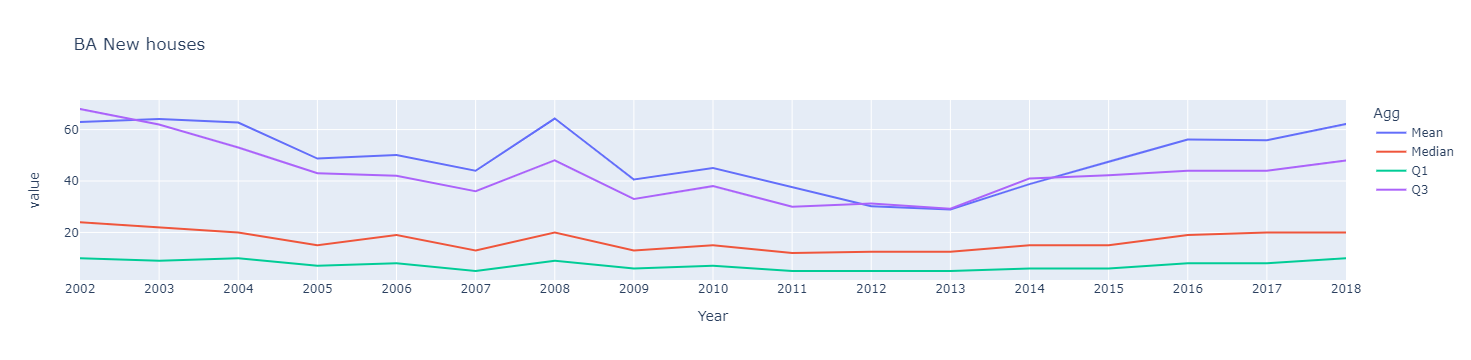

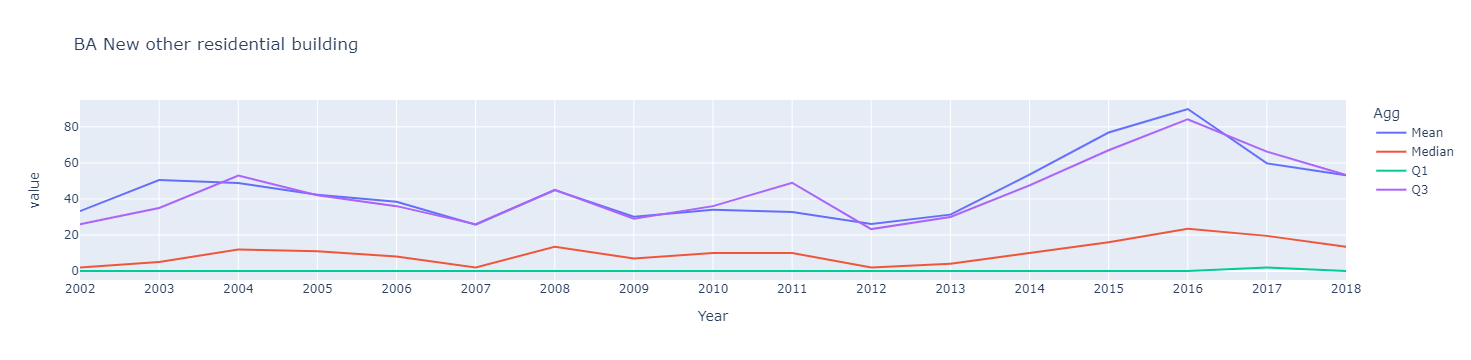

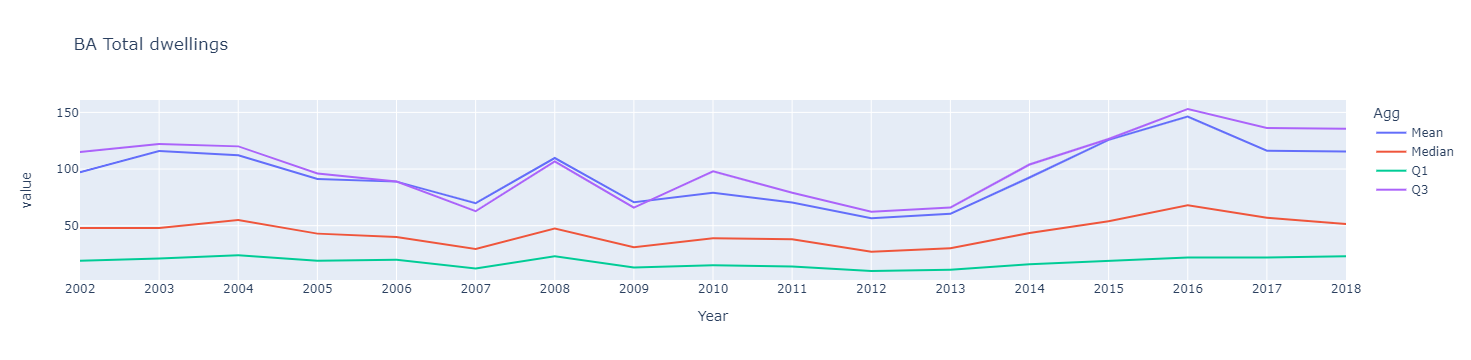

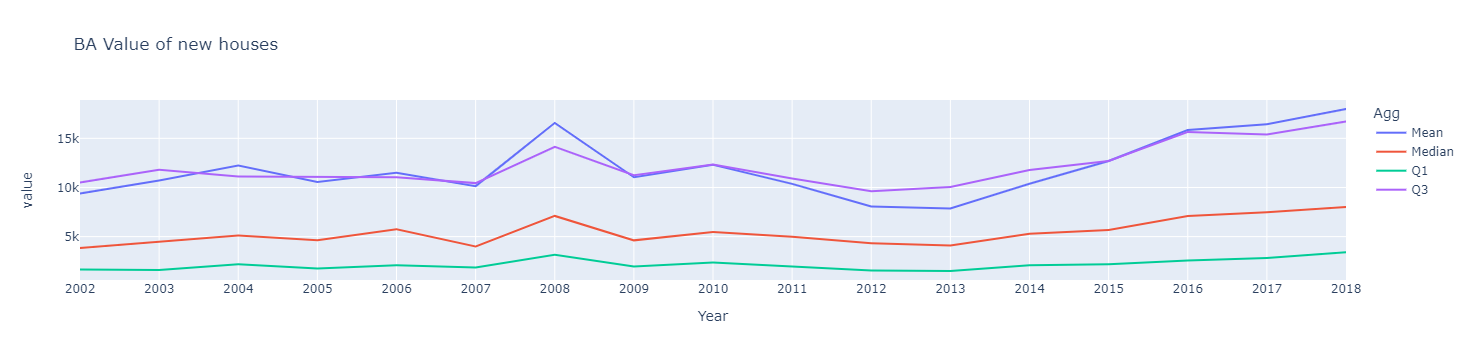

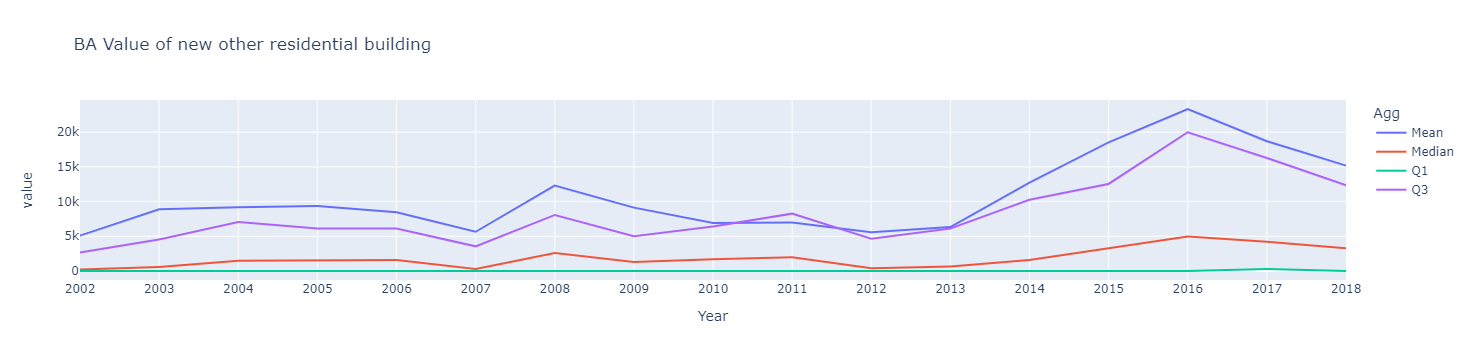

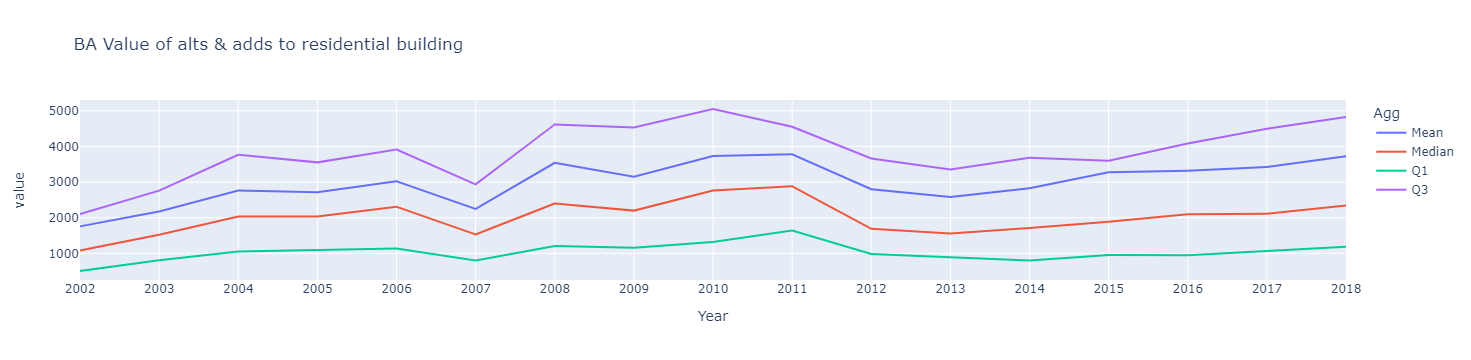

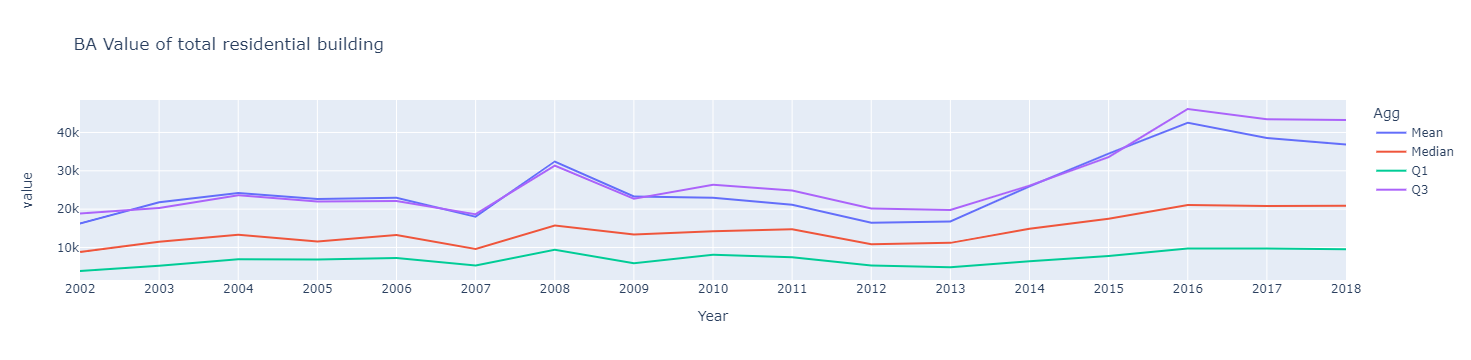

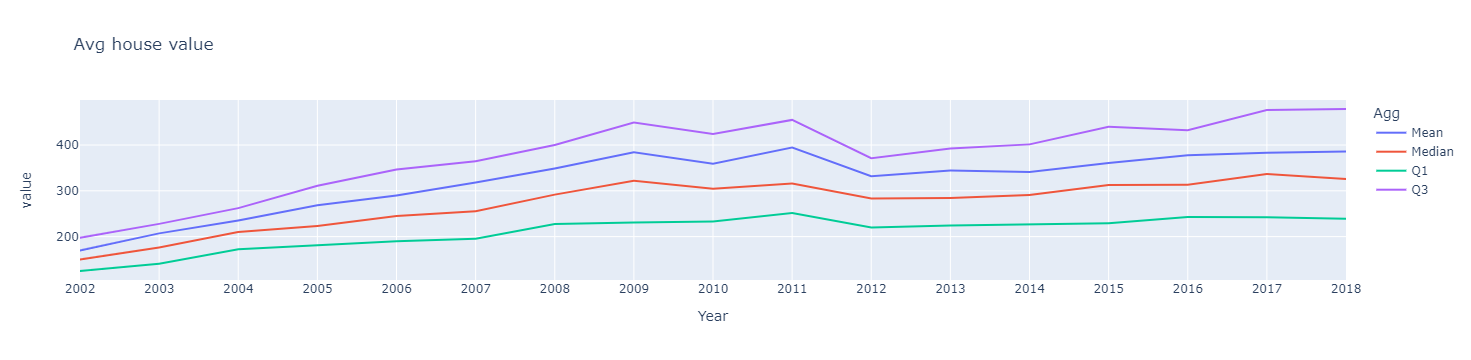

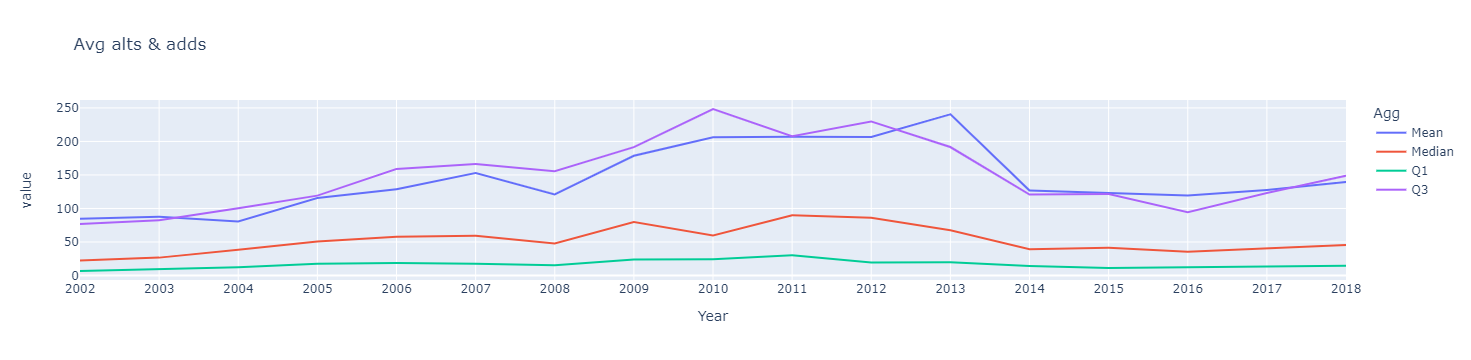

In [23]:
# Plot how Q1, median, Q3 and Mean has moved over time for Building Approvals
for col in df_time_agg.columns:
    if col not in ('Year', 'Agg'):
        chart = col
        df_plot = df_time_agg.pivot(index='Year', columns=agg_label)[col].reset_index()
        fig = px.line(df_plot, x="Year", y=df_plot.columns,
                      title=col)
        fig.update_xaxes(
            dtick="M1")
        fig.show()

In [78]:
df_time[df_time['ABS Code'] == 309071258]

ABS Code  Year  BA New houses  BA New other residential building  \
239   309071258  2002            NaN                                NaN   
503   309071258  2003            NaN                                NaN   
767   309071258  2004            NaN                                NaN   
1031  309071258  2005            NaN                                NaN   
1295  309071258  2006            NaN                                NaN   
1559  309071258  2007          486.0                              172.0   
1823  309071258  2008          613.0                              100.0   
2087  309071258  2009          369.0                               32.0   
2351  309071258  2010          511.0                               53.0   
2615  309071258  2011          378.0                               71.0   
2879  309071258  2012          280.0                               51.0   
3143  309071258  2013          274.0                                4.0   
3407  309071258  2014          430.0                               23.0   
3671  309071258  2015          385.0                               84.0   
3935  309071258  2016          451.0                               92.0   
4199  309071258  2017          304.0                               99.0   
4463  309071258  2018          224.0                              110.0   

      BA Total dwellings  BA Value of new houses  \
239                  NaN                     NaN   
503                  NaN                     NaN   
767                  NaN                     NaN   
1031                 NaN                     NaN   
1295                 NaN                     NaN   
1559               658.0                102885.0   
1823               716.0                140724.2   
2087               401.0                 90524.6   
2351               564.0                127716.9   
2615               449.0                 95053.8   
2879               332.0                 69899.7   
3143               278.0                 66712.1   
3407               454.0                104633.8   
3671               469.0                 93554.2   
3935               543.0                120141.5   
4199               403.0                 90248.8   
4463               334.0                 70969.0   

      BA Value of new other residential building  \
239                                          NaN   
503                                          NaN   
767                                          NaN   
1031                                         NaN   
1295                                         NaN   
1559                                     27227.3   
1823                                     19667.2   
2087                                      6727.2   
2351                                      9052.0   
2615                                     10910.2   
2879                                      8755.4   
3143                                       686.9   
3407                                      3546.5   
3671                                     16006.9   
3935                                     15668.8   
4199                                     20242.4   
4463                                     42567.0   

      BA Value of alts & adds to residential building  \
239                                               NaN   
503                                               NaN   
767                                               NaN   
1031                                              NaN   
1295                                              NaN   
1559                                            808.4   
1823                                           2270.3   
2087                                           1896.0   
2351                                           3027.3   
2615                                           3582.5   
2879                                           2482.9   
3143                                           1735.0   
3407                                     

---

## Question 2

> Please give a description of any surprising findings or spurious factors that you believe may generalize poorly to new regions.

Some notes:
* Solar panel installations ~ Solar water heaters - these probably do not indicate opportunities but are people deciding to install both at once


---

---

## Question 3

> Please provide any caveats (or “gotchas”) that you believe may undermine the power of any predictive model developed from these factors.

---

---

## Question 4

> Please outline any data you would wish to augment this dataset with to make a more powerful predictive model or any experiments you would propose to rule out spurious correlations.

---

Keep track of thoughts for later...

Some things that could be useful:

Financial data:
* Electricity prices over time
* Average wages by industry
* Distance to customer could be recorded as a 2d vector to enhance geometric understanding of this relationship

Demographic data:
* Election results
* Average building height?

Geographical data:
* Weather
* Altitude

Generally:
* More time points
* 

---